In [1]:
%load_ext jupyter_black

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
from matplotlib.ticker import PercentFormatter
import os
import plotly.express as px
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
import joblib

color_palette = sns.color_palette("Dark2")
color_palette

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]

# Load and clean the data

In [3]:
steel_raw = pd.read_excel("../data/steel_strength.xlsx")

In [4]:
steel_raw.head()

,Alloy code,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (Â°C),0.2% Proof Stress (MPa),Tensile Strength (MPa)
0,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,27,342,490
1,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,100,338,454
2,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,200,337,465
3,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,300,346,495
4,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,400,316,489


In [5]:
steel_raw.shape

(915, 18)

In [6]:
def data_clean(df):
    df = df.copy()
    # Clean columns names
    df = df.rename(columns=lambda x: x.strip())
    df = df.rename(
        columns={
            "Alloy code": "alloy_code",
            "C": "carbon",
            "Si": "silicon",
            "Mn": "manganese",
            "P": "phosphorus",
            "S": "sulphur",
            "Ni": "nickel",
            "Cr": "chromium",
            "Mo": "molybdenum",
            "Cu": "cooper",
            "V": "vanadium",
            "Al": "aluminum",
            "N": "nitrogen",
            "Ceq": "carbon_equivalent",
            "Nb + Ta": "niobium_tantalum",
            "Temperature (Â°C)": "temperature_c",
            "0.2% Proof Stress (MPa)": "yield_strength_mpa",
            "Tensile Strength (MPa)": "tensile_strength_mpa",
        }
    )
    return df

In [7]:
steel = steel_raw.pipe(data_clean)

In [8]:
steel.head()

,alloy_code,carbon,silicon,manganese,phosphorus,sulphur,nickel,chromium,molybdenum,cooper,vanadium,aluminum,nitrogen,carbon_equivalent,niobium_tantalum,temperature_c,yield_strength_mpa,tensile_strength_mpa
0,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,27,342,490
1,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,100,338,454
2,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,200,337,465
3,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,300,346,495
4,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,400,316,489


In [9]:
components = (
    steel.loc[:, "carbon":"niobium_tantalum"]
    .drop(columns="carbon_equivalent")
    .columns.tolist()
)
components_name = [
    "Carbon",
    "Silicon",
    "Manganese",
    "Phosphorus",
    "Sulfur",
    "Nickel",
    "Chromium",
    "Molybdenum",
    "Cooper",
    "Vanadium",
    "Aluminum",
    "Nitrogen",
    "Niobium + Tantalum",
]
targets = ["yield_strength_mpa", "tensile_strength_mpa"]
targets_name = ["Yield Strength (MPa)", "Tensile Strength (MPa)"]
components_dict = dict(zip(components, components_name))
targets_dict = dict(zip(targets, targets_name))

I think that each alloy_code should have the same composition, the only difference between them should be the temperature, which modifies the targets, is this right?

In [10]:
print(
    f"The number of distinct alloy codes in the dataset is: {steel.alloy_code.nunique()}"
)
print(
    f"The number of distinct combinations of alloy codes and components is: {steel.drop_duplicates(subset=['alloy_code'] + components).shape[0]}"
)

The number of distinct alloy codes in the dataset is: 95
The number of distinct combinations of alloy codes and components is: 95


As suspected, there are `95` different steel alloys in the dataset. For each alloy, probes at different temperature were tested, and for each test we get a `yield strength` and a `tensile strength` value. Let's observe a sample of the data

In [11]:
n_alloys = 10
data = steel[
    steel["alloy_code"].isin(np.random.choice(steel.alloy_code.unique(), n_alloys))
].sort_values("temperature_c")

px.line(
    data,
    x="temperature_c",
    y="tensile_strength_mpa",
    color="alloy_code",
    template="simple_white",
    title="Tensile strength for different steel alloys",
    labels={
        "tensile_strength_mpa": "Tensile Strength (MPa)",
        "temperature_c": "Temperature (°C)",
        "alloy_code": "Alloy code",
    },
)

This is an important consideration for the train and test split of the data, since `alloy_code` is a grouping variable, it could be a potential source of [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)). We want our machine learning algorithm to be able to generalise as much as possible, so it can predict `yield strength` and `tensile strength` for alloys that it hasn't been trained on. If we randomly split the data into train and test sets without considering this grouping factor, the algorithm will already have learn the profile of this specific alloy components combination, giving us an overstimation of the model's utility.

Since we have 95 different alloys in the dataset, the splitting strategy in this case will be to take 20% of this alloys codes (19 alloys) and put them in the test set, while the remaining 80% (76 alloys) go to the train set

In [12]:
# Split the data into train and test sets
test_alloys = steel["alloy_code"].drop_duplicates().sample(frac=0.2, random_state=42)

train = steel[~steel["alloy_code"].isin(test_alloys)]
test = steel[steel["alloy_code"].isin(test_alloys)]

if not os.path.exists("../data/splits"):
    os.mkdir("../data/splits")

train.to_csv("../data/splits/train.csv", index=False)
test.to_csv("../data/splits/test.csv", index=False)

In [13]:
print(
    f"The number of different alloys codes in the train set is {train.alloy_code.nunique()}"
)
print(
    f"The number of different alloys codes in the test set is {test.alloy_code.nunique()}"
)
print(
    f"The number of alloy codes presented in both train and test set is {len(set(train.alloy_code).intersection(set(test.alloy_code)))}"
)

The number of different alloys codes in the train set is 76
The number of different alloys codes in the test set is 19
The number of alloy codes presented in both train and test set is 0


# Exploratory Data Analysis

In [14]:
train = pd.read_csv("../data/splits/train.csv")
test = pd.read_csv("../data/splits/test.csv")

components = (
    train.loc[:, "carbon":"niobium_tantalum"]
    .drop(columns="carbon_equivalent")
    .columns.tolist()
)
targets = ["yield_strength_mpa", "tensile_strength_mpa"]

In [15]:
# No missing values in the data
train.isnull().sum()

alloy_code              0
carbon                  0
silicon                 0
manganese               0
phosphorus              0
sulphur                 0
nickel                  0
chromium                0
molybdenum              0
cooper                  0
vanadium                0
aluminum                0
nitrogen                0
carbon_equivalent       0
niobium_tantalum        0
temperature_c           0
yield_strength_mpa      0
tensile_strength_mpa    0
dtype: int64

In [16]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
carbon,732.0,0.172186,0.058005,0.0900,0.1300,0.1600,0.200,0.3400
silicon,732.0,0.319358,0.092116,0.1800,0.2500,0.3000,0.380,0.5200
manganese,732.0,0.826940,0.348525,0.4200,0.4900,0.7000,1.230,1.4800
phosphorus,732.0,0.014717,0.005402,0.0060,0.0120,0.0140,0.018,0.0300
sulphur,732.0,0.010719,0.003757,0.0040,0.0080,0.0100,0.013,0.0220
nickel,732.0,0.142480,0.175896,0.0000,0.0200,0.0500,0.210,0.6000
chromium,732.0,0.407097,0.448991,0.0000,0.0400,0.1100,0.960,1.3100
molybdenum,732.0,0.420891,0.373174,0.0050,0.0600,0.5000,0.560,1.3500
cooper,732.0,0.079331,0.061245,0.0000,0.0300,0.0600,0.110,0.2500
vanadium,732.0,0.054760,0.092034,0.0000,0.0000,0.0000,0.060,0.3000


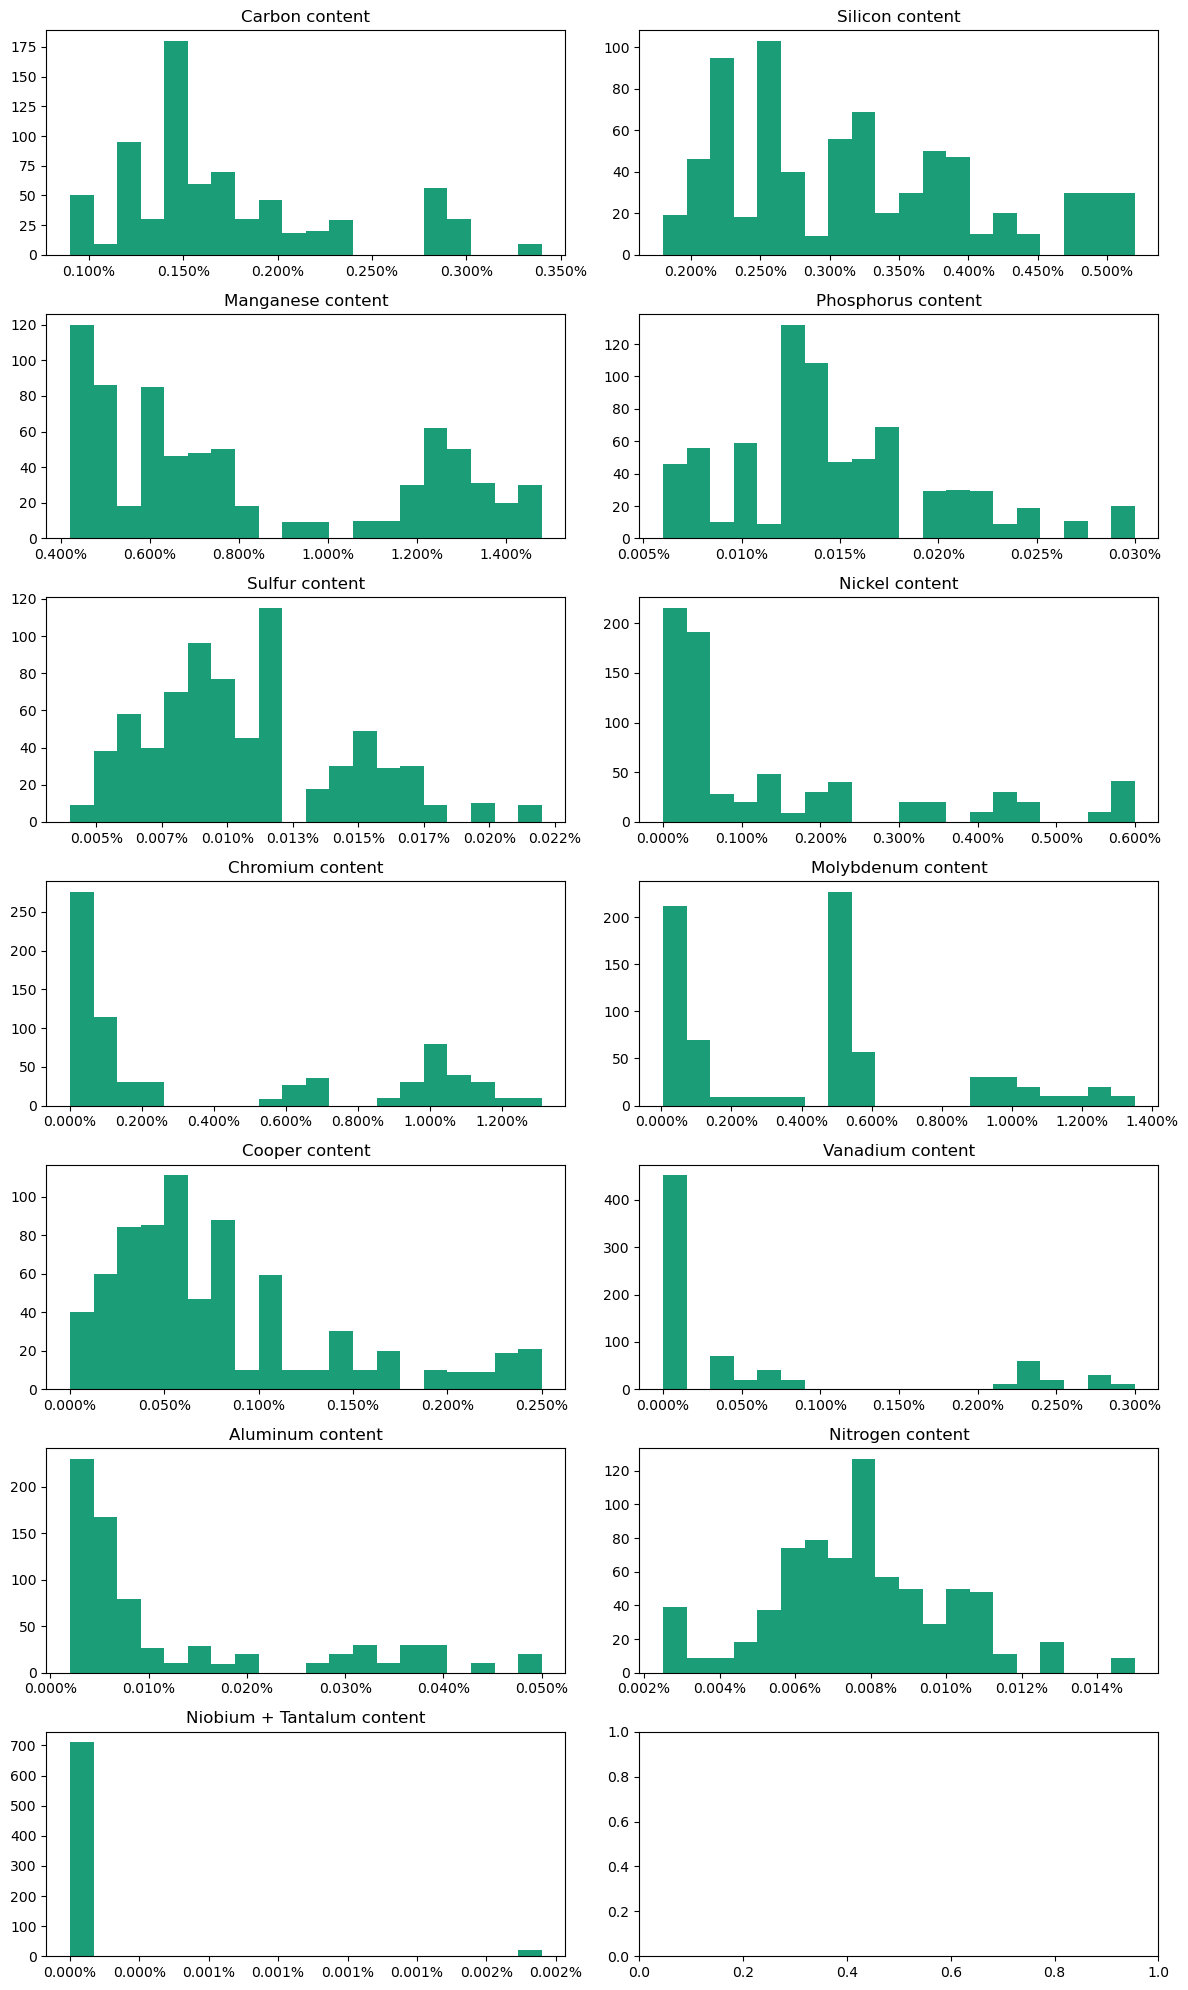

In [17]:
# Distribution of the components of the steel

fig, axs = plt.subplots(7, 2, figsize=(12, 20))
axs = axs.flatten()
for comp, ax in zip(components, axs):
    ax.hist(train[comp], bins=20, color=color_palette[0])
    ax.set_title(f"{components_dict[comp]} content")
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=3))
plt.tight_layout()

From the carbon content distribution, we can see that we are dealing with low-carbon steel.

Low-carbon steel is characterized by a low ratio of carbon to iron. By definition, low-carbon consists of less than 0.30% of carbon. Also known as mild steel, it costs less to produce than both medium-carbon and high-carbon steel. In addition to its low cost, low-carbon steel is more pliable, which may improve its effectiveness for certain applications while lowering its effectiveness for other applications.

This is something we should be aware of for our calculator, since it will only work appropriately for low-carbon steel inputs.

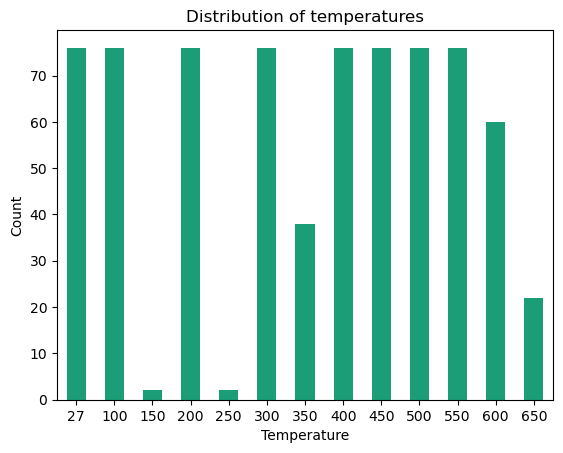

In [18]:
ax = train["temperature_c"].value_counts().sort_index().plot.bar(color=color_palette[0])
ax.set_title("Distribution of temperatures")
ax.set_ylabel("Count")
ax.set_xlabel("Temperature")
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=0)
plt.show()

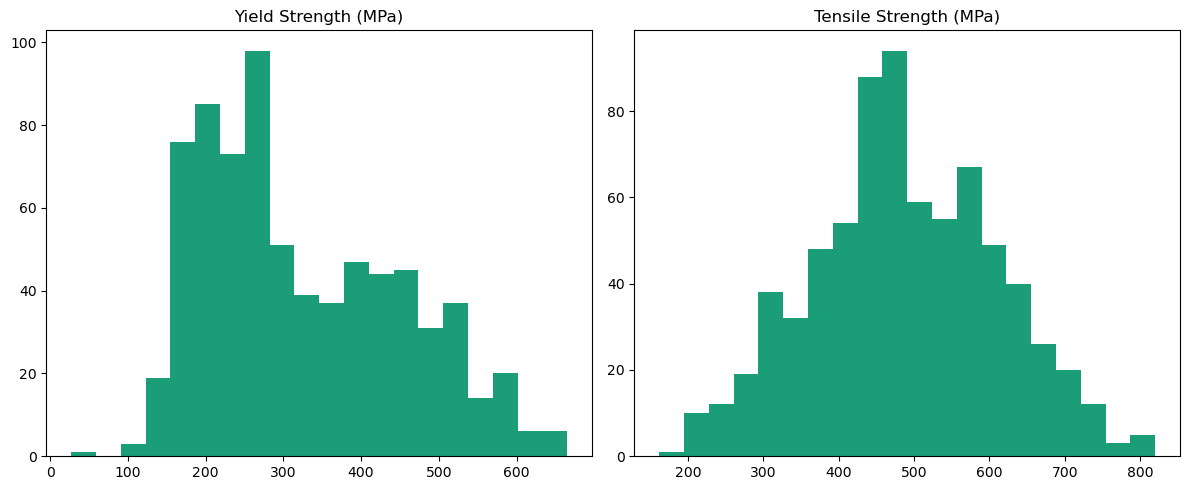

In [19]:
# Distribution of the targets

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.flatten()
for target, ax in zip(targets, axs):
    ax.hist(train[target], bins=20, color=color_palette[0])
    ax.set_title(f"{targets_dict[target]}")
plt.tight_layout()

## Target analysis

In [20]:
# Yield Strength should be always lower than Tensile Strength, is this condition met?

(train["yield_strength_mpa"] <= train["tensile_strength_mpa"]).value_counts()

True     731
False      1
dtype: int64

In [21]:
# This has to be an error! This is the sample with the lower tensile strength of the whole dataset.
train[train["yield_strength_mpa"] > train["tensile_strength_mpa"]]

,alloy_code,carbon,silicon,manganese,phosphorus,sulphur,nickel,chromium,molybdenum,cooper,vanadium,aluminum,nitrogen,carbon_equivalent,niobium_tantalum,temperature_c,yield_strength_mpa,tensile_strength_mpa
537,VbN,0.15,0.52,0.78,0.01,0.009,0.12,1.17,0.98,0.08,0.23,0.003,0.0106,0.0,0.0,550,408,162


In [22]:
train[train["alloy_code"] == "VbN"].sort_values("temperature_c")

,alloy_code,carbon,silicon,manganese,phosphorus,sulphur,nickel,chromium,molybdenum,cooper,vanadium,aluminum,nitrogen,carbon_equivalent,niobium_tantalum,temperature_c,yield_strength_mpa,tensile_strength_mpa
530,VbN,0.15,0.52,0.78,0.01,0.009,0.12,1.17,0.98,0.08,0.23,0.003,0.0106,0.0,0.0,27,555,680
531,VbN,0.15,0.52,0.78,0.01,0.009,0.12,1.17,0.98,0.08,0.23,0.003,0.0106,0.0,0.0,100,534,654
532,VbN,0.15,0.52,0.78,0.01,0.009,0.12,1.17,0.98,0.08,0.23,0.003,0.0106,0.0,0.0,200,501,619
533,VbN,0.15,0.52,0.78,0.01,0.009,0.12,1.17,0.98,0.08,0.23,0.003,0.0106,0.0,0.0,300,496,607
534,VbN,0.15,0.52,0.78,0.01,0.009,0.12,1.17,0.98,0.08,0.23,0.003,0.0106,0.0,0.0,400,480,582
535,VbN,0.15,0.52,0.78,0.01,0.009,0.12,1.17,0.98,0.08,0.23,0.003,0.0106,0.0,0.0,450,450,540
536,VbN,0.15,0.52,0.78,0.01,0.009,0.12,1.17,0.98,0.08,0.23,0.003,0.0106,0.0,0.0,500,433,505
537,VbN,0.15,0.52,0.78,0.01,0.009,0.12,1.17,0.98,0.08,0.23,0.003,0.0106,0.0,0.0,550,408,162
538,VbN,0.15,0.52,0.78,0.01,0.009,0.12,1.17,0.98,0.08,0.23,0.003,0.0106,0.0,0.0,600,344,397
539,VbN,0.15,0.52,0.78,0.01,0.009,0.12,1.17,0.98,0.08,0.23,0.003,0.0106,0.0,0.0,650,252,333


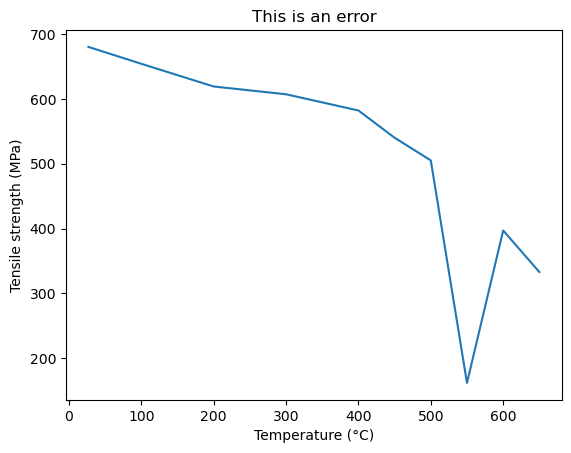

In [23]:
train[train["alloy_code"] == "VbN"].sort_values("temperature_c").plot(
    x="temperature_c", y="tensile_strength_mpa"
)
plt.title("This is an error")
plt.ylabel("Tensile strength (MPa)")
plt.xlabel("Temperature (°C)")
plt.legend().remove()
plt.show()

In [24]:
vbn = train[train["alloy_code"] == "VbN"]
correct_vbn = vbn.query("tensile_strength_mpa > 300")

model = smf.ols("tensile_strength_mpa ~ temperature_c", data=correct_vbn).fit()
model.predict(pd.DataFrame({"temperature_c": [550]}))

0    450.068859
dtype: float64

450 MPa is the predicted tensile strength of this point for our model. Since the original data says it's 162 MPa, there was probably a input error, and the correct value in 462 MPa. I will manually introduce this value in the dataset.

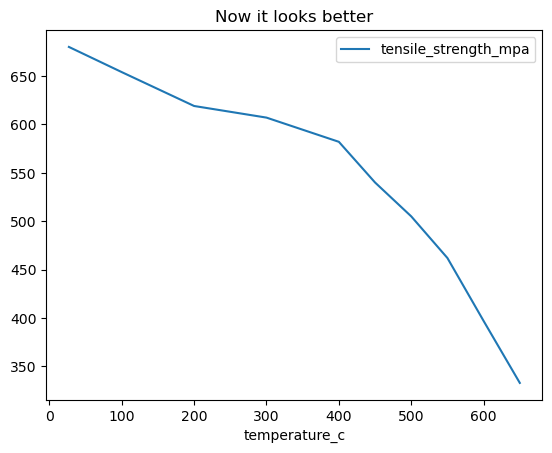

In [25]:
train.loc[
    (train["alloy_code"] == "VbN") & (train["temperature_c"] == 550),
    "tensile_strength_mpa",
] = 462

train[train["alloy_code"] == "VbN"].sort_values("temperature_c").plot(
    x="temperature_c", y="tensile_strength_mpa"
)
plt.title("Now it looks better")
plt.show()

# PCA Analysis

In [26]:
scaler = StandardScaler()
components_sc = scaler.fit_transform(train[components + ["temperature_c"]])
pca = PCA(n_components=2)
pca.fit(components_sc)

PCA(n_components=2)

In [27]:
pca_rs = pca.transform(components_sc)

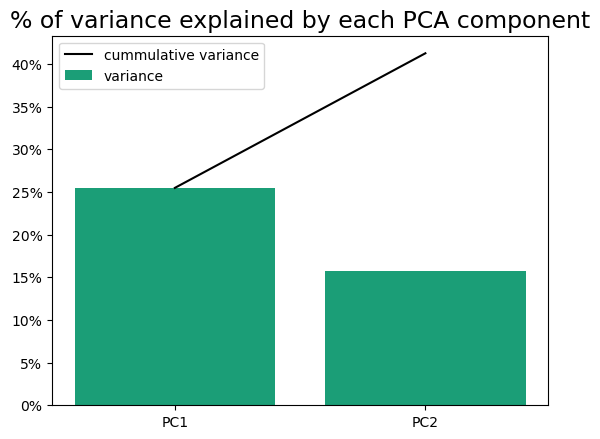

In [28]:
plt.bar(
    x=range(pca_rs.shape[1]),
    height=pca.explained_variance_ratio_,
    color=color_palette[0],
)
plt.plot(range(pca_rs.shape[1]), pca.explained_variance_ratio_.cumsum(), c="black")
plt.legend(["cummulative variance", "variance"])
plt.xticks(
    ticks=range(pca_rs.shape[1]), labels=[f"PC{i + 1}" for i in range(pca_rs.shape[1])]
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.title("% of variance explained by each PCA component", fontsize=17)
plt.show()

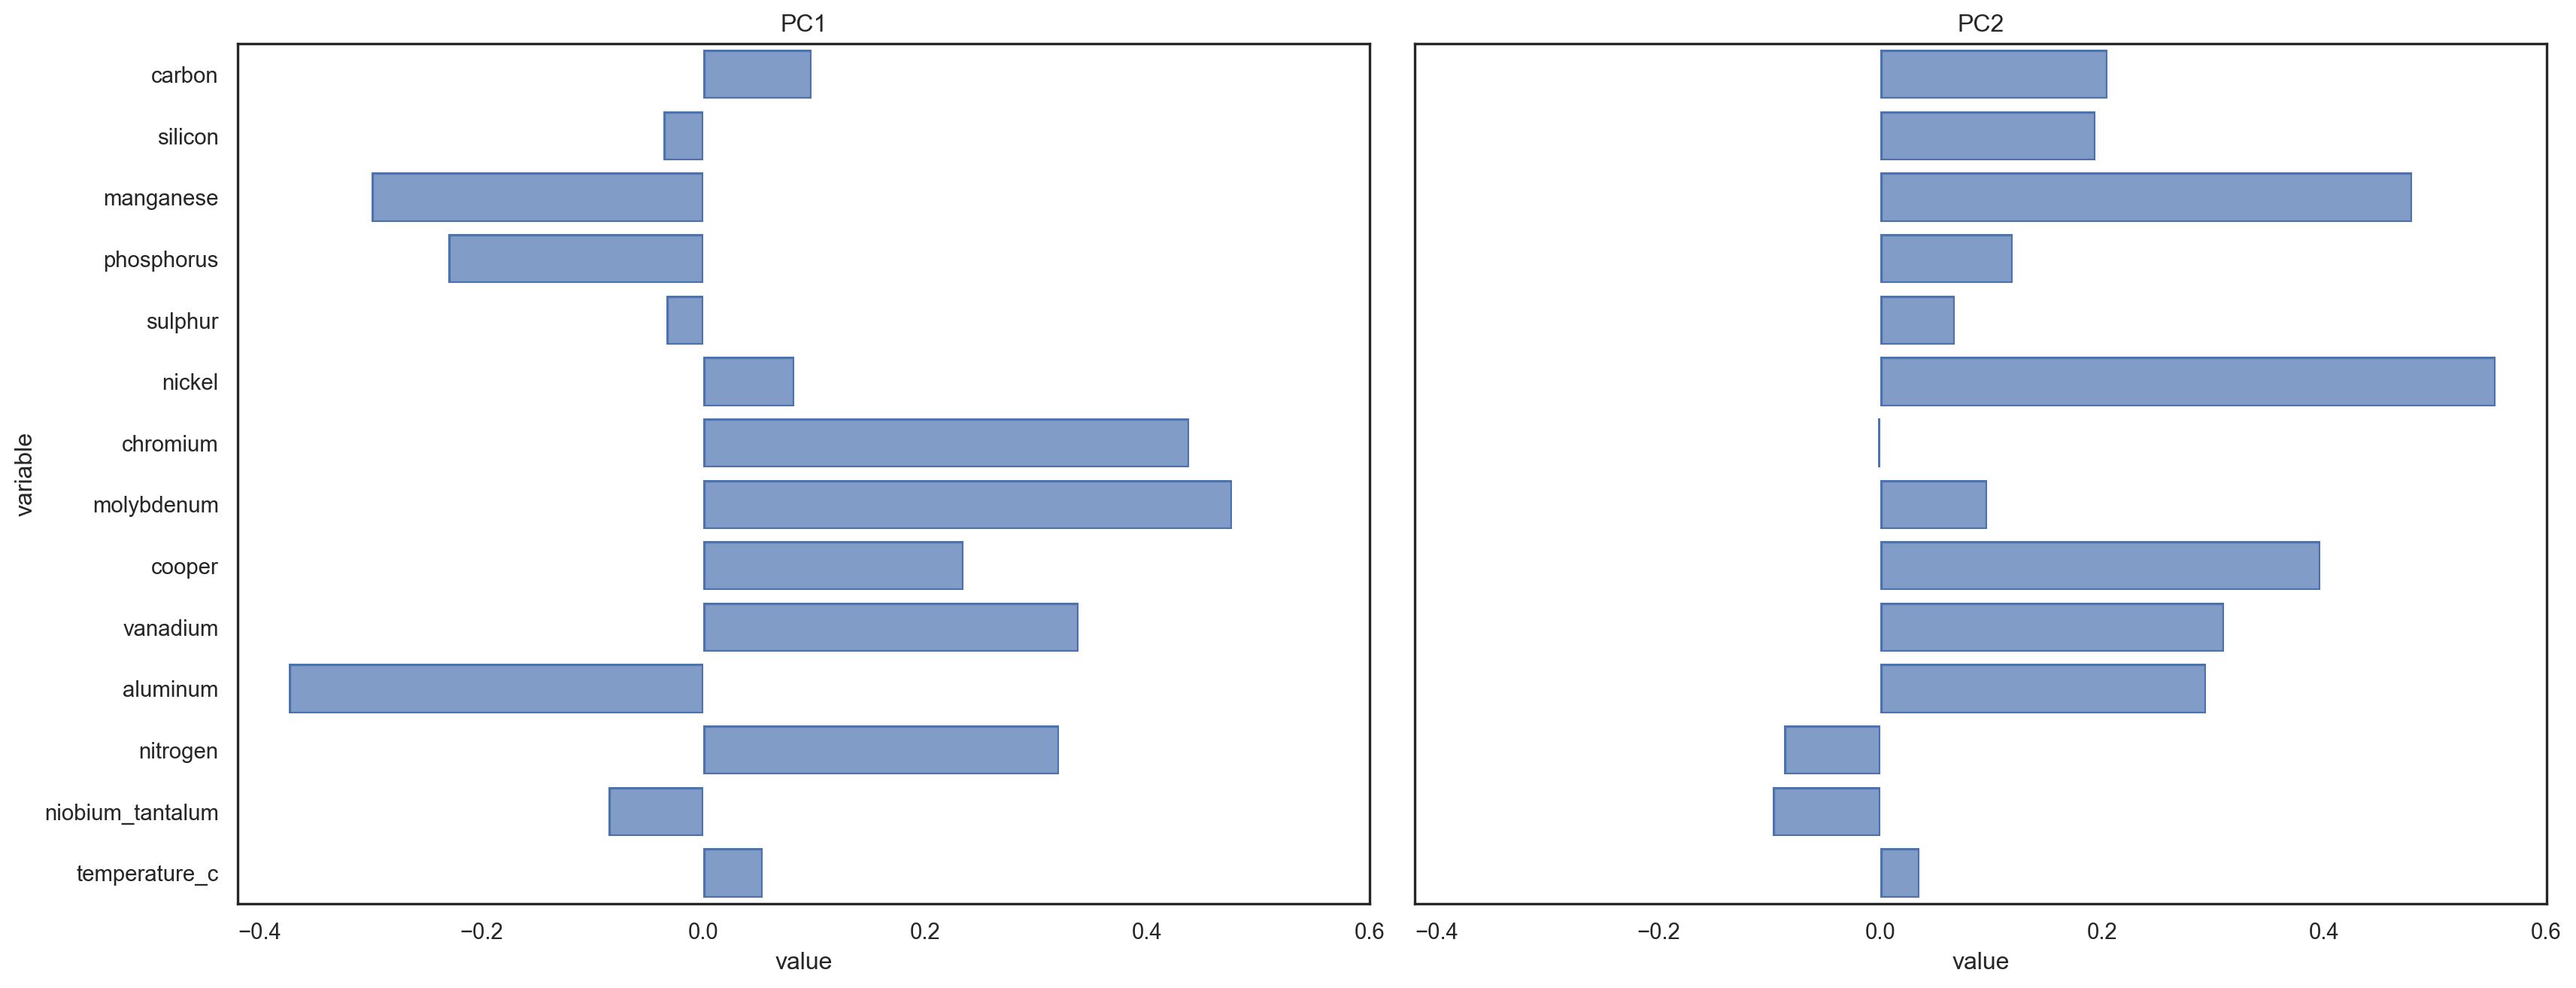

In [29]:
pca_df = pd.DataFrame(pca_rs, columns=[f"PC{i + 1}" for i in range(pca_rs.shape[1])])

pca_comps = pd.DataFrame(
    pca.components_, index=pca_df.columns, columns=components + ["temperature_c"]
).reset_index(names="component")

pca_comps_long = pca_comps.melt(id_vars="component")

(
    so.Plot(pca_comps_long, "value", "variable")
    .add(so.Bar())
    .facet("component", wrap=4)
    .layout(size=(18, 7))
    .theme({**axes_style("white")})
)

In [30]:
px.scatter(
    x=pca_rs[:, 0],
    y=pca_rs[:, 1],
    color=train["tensile_strength_mpa"],
    labels={"color": "Tensile Strength (MPa)"},
    template="simple_white",
    color_continuous_scale="Cividis",
)

<Axes: >

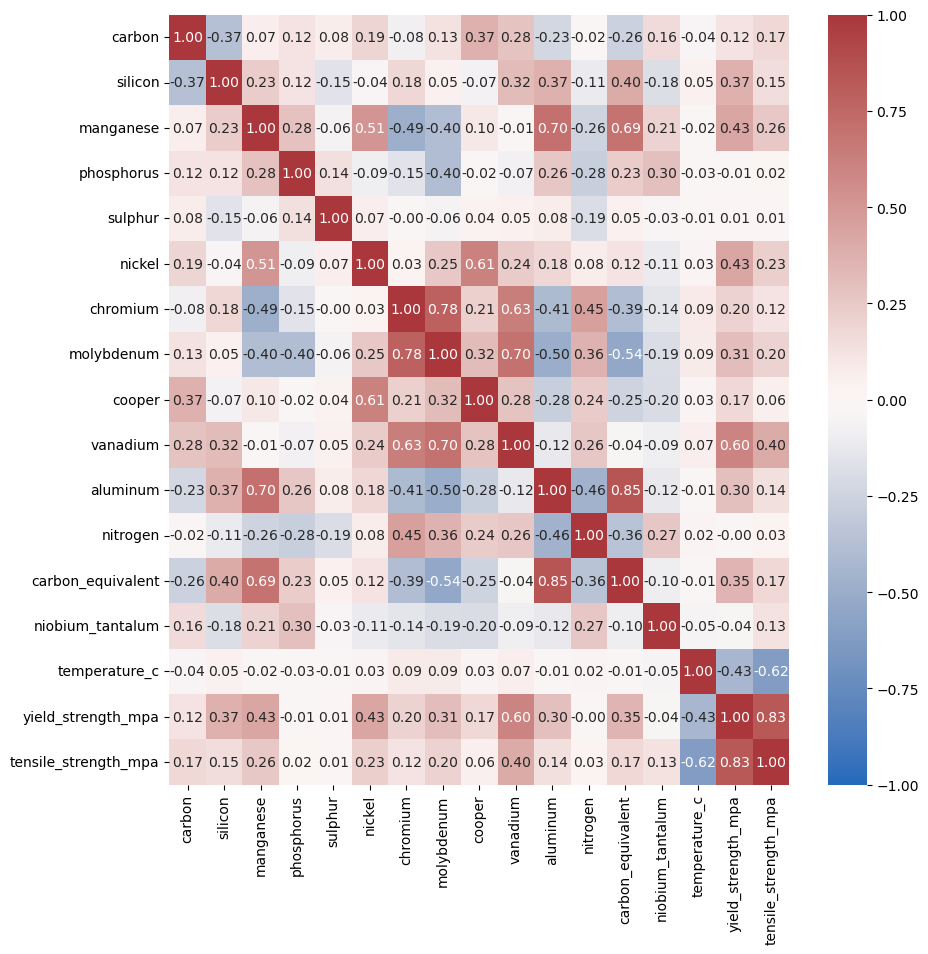

In [31]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    train.select_dtypes("number").corr(),
    annot=True,
    center=0,
    vmax=1,
    vmin=-1,
    cmap="vlag",
    fmt=".2f",
)

# Models

The evaluation metric for this models will be **Root Mean Square Error**

## Linear model

First I will create a linear model with the `statsmodels` package

In [32]:
predictors = components + ["temperature_c"]
X = sm.add_constant(train[predictors])

In [33]:
results = sm.OLS(train["tensile_strength_mpa"], X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     tensile_strength_mpa   R-squared:                       0.668
Model:                              OLS   Adj. R-squared:                  0.661
Method:                   Least Squares   F-statistic:                     102.9
Date:                  Wed, 26 Jul 2023   Prob (F-statistic):          7.78e-161
Time:                          14:58:31   Log-Likelihood:                -4150.2
No. Observations:                   732   AIC:                             8330.
Df Residuals:                       717   BIC:                             8399.
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              523.3501     36.884     14.189      0.000     450.936     595.764
carbon             127.3553     69.457      1.834      0.067      -9.008     263.718
silicon             47.0355     42.672      1.102      0.271     -36.741     130.812
manganese           58.3307     20.644      2.826      0.005      17.800      98.861
phosphorus       -1249.5337    684.738     -1.825      0.068   -2593.865      94.798
sulphur            173.2453    810.821      0.214      0.831   -1418.621    1765.112
nickel              50.1747     31.081      1.614      0.107     -10.846     111.195
chromium             6.5027     13.722      0.474      0.636     -20.438      33.443
molybdenum          48.6697     19.460      2.501      0.013      10.464      86.875
cooper            -152.0747     79.307     -1.918      0.056    -307.776       3.626
vanadium           443.4069     62.151      7.134      0.000     321.387     565.427
aluminum          1006.2268    455.774      2.208      0.028     111.415    1901.038
nitrogen         -2355.5023   1675.953     -1.405      0.160   -5645.864     934.859
niobium_tantalum  6.469e+04   1.46e+04      4.432      0.000     3.6e+04    9.33e+04
temperature_c       -0.4148      0.014    -29.714      0.000      -0.442      -0.387
==============================================================================
Omnibus:                       35.159   Durbin-Watson:                   0.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.719
Skew:                           0.034   Prob(JB):                     0.000636
Kurtosis:                       2.309   Cond. No.                     2.22e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Evaluating the model

In [34]:
# Scores on training data
mean_squared_error(train["tensile_strength_mpa"], results.fittedvalues, squared=False)

70.15838365842247

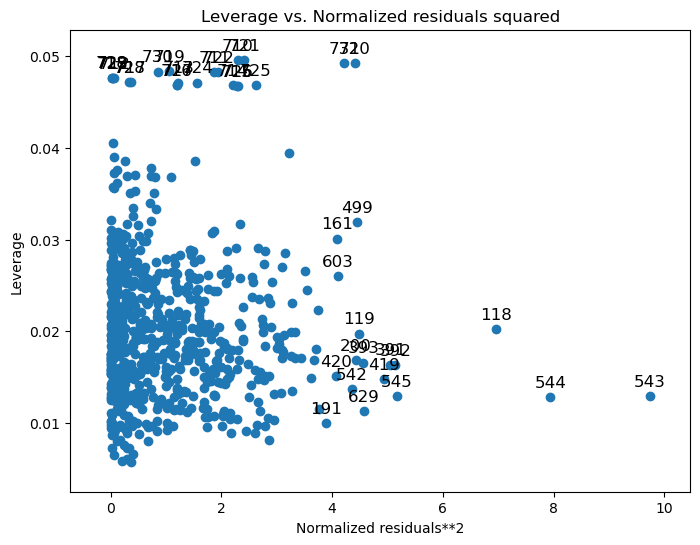

In [35]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2

fig, ax = plt.subplots(figsize=(8, 6))
fig = plot_leverage_resid2(results, ax=ax)

<Axes: ylabel='Frequency'>

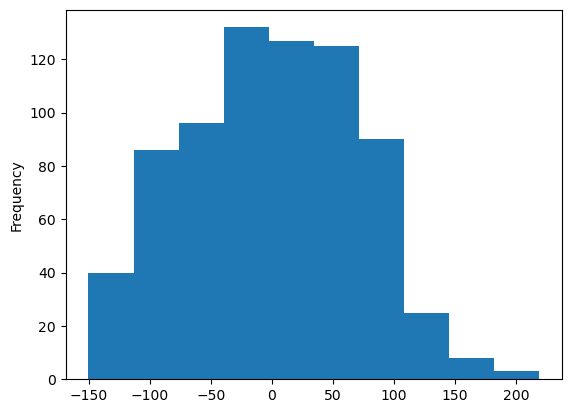

In [36]:
results.resid.plot.hist()

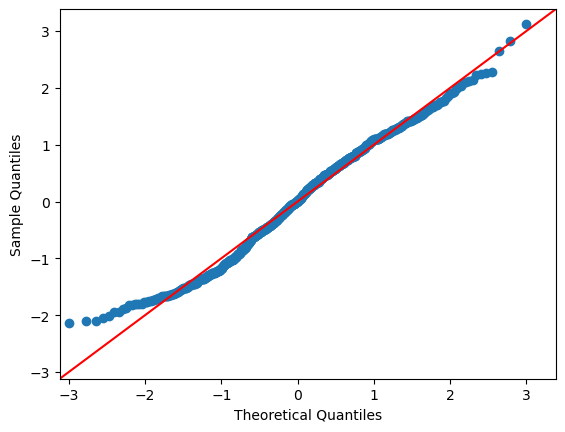

In [37]:
fig = sm.qqplot(results.resid, fit=True, line="45")
plt.show()

In [38]:
resid_df = train.assign(
    preds=results.fittedvalues, resid=results.resid, resid_abs=abs(results.resid)
)
resid_df.sort_values("resid_abs", ascending=False).head(10)

,alloy_code,carbon,silicon,manganese,phosphorus,sulphur,nickel,chromium,molybdenum,cooper,...,aluminum,nitrogen,carbon_equivalent,niobium_tantalum,temperature_c,yield_strength_mpa,tensile_strength_mpa,preds,resid,resid_abs
543,CbC,0.16,0.28,1.14,0.017,0.016,0.33,0.240,0.08,0.13,...,0.015,0.0067,0.437,0.0,300,566,701,482.047180,218.952820,218.952820
544,CbC,0.16,0.28,1.14,0.017,0.016,0.33,0.240,0.08,0.13,...,0.015,0.0067,0.437,0.0,350,526,659,461.308790,197.691210,197.691210
118,CAJ,0.20,0.20,0.47,0.007,0.009,0.00,0.056,0.01,0.07,...,0.005,0.0110,0.000,0.0,200,291,650,464.828870,185.171130,185.171130
545,CbC,0.16,0.28,1.14,0.017,0.016,0.33,0.240,0.08,0.13,...,0.015,0.0067,0.437,0.0,400,530,600,440.570401,159.429599,159.429599
392,MFA,0.12,0.25,0.48,0.008,0.012,0.04,0.640,0.51,0.04,...,0.006,0.0130,0.000,0.0,400,237,564,404.889086,159.110914,159.110914
391,MFA,0.12,0.25,0.48,0.008,0.012,0.04,0.640,0.51,0.04,...,0.006,0.0130,0.000,0.0,300,259,604,446.365865,157.634135,157.634135
419,MFF,0.12,0.24,0.47,0.008,0.011,0.04,0.710,0.49,0.06,...,0.006,0.0130,0.000,0.0,400,246,556,400.102481,155.897519,155.897519
629,CbN,0.12,0.37,1.32,0.012,0.012,0.22,0.030,0.07,0.07,...,0.030,0.0064,0.387,0.0,600,185,258,408.099367,-150.099367,150.099367
393,MFA,0.12,0.25,0.48,0.008,0.012,0.04,0.640,0.51,0.04,...,0.006,0.0130,0.000,0.0,450,228,534,384.150696,149.849304,149.849304
119,CAJ,0.20,0.20,0.47,0.007,0.009,0.00,0.056,0.01,0.07,...,0.005,0.0110,0.000,0.0,300,189,572,423.352091,148.647909,148.647909


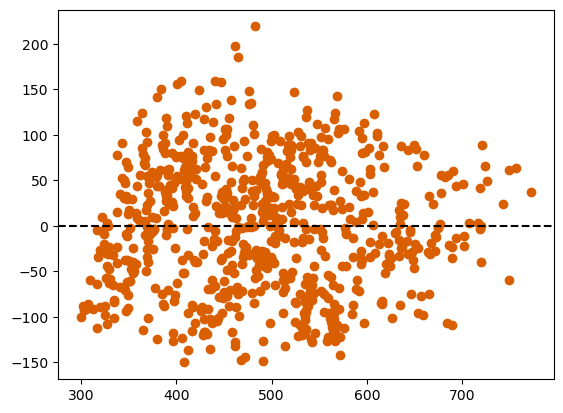

In [39]:
plt.scatter(results.fittedvalues, results.resid, color=color_palette[1])
plt.axhline(0, color="k", linestyle="--")

In [40]:
# No correlation of fitted values and residual values, that is good
np.corrcoef(results.fittedvalues, results.resid)

array([[ 1.00000000e+00, -8.60565121e-12],
       [-8.60565121e-12,  1.00000000e+00]])

## Lasso Model

As we did before in the train/test split, the cross validation also requires to be made considering the data groups. Fortunatelly, there is a sklearn class called `GroupKFold` that could help us with that

In [41]:
group_folds = GroupKFold(n_splits=4)
train_target = train[
    [
        "yield_strength_mpa",
        "tensile_strength_mpa",
    ]
].copy()


def evaluate_estimator(
    estimator, X=train[predictors], y=train_target, groups=train["alloy_code"]
):
    predictions = cross_val_predict(
        estimator,
        X,
        y,
        groups=groups,
        cv=group_folds,
        n_jobs=-1,
    )
    error = mean_squared_error(predictions, y, squared=False, multioutput="raw_values")
    print(f"The RMSE for the Yield strength is {error[0].round(3)}")
    print(f"The RMSE for the Tensile strength is {error[1].round(3)}")

    return predictions

In [42]:
scaler = StandardScaler()
lasso = Lasso()
params_grid = {"lasso__alpha": np.logspace(-3, 2, 150)}

lasso_pipe = make_pipeline(scaler, lasso)

grid_rs = GridSearchCV(
    lasso_pipe,
    params_grid,
    scoring="neg_root_mean_squared_error",
    cv=group_folds,
    n_jobs=-1,
)

grid_rs.fit(train[predictors], train_target, groups=train["alloy_code"])

GridSearchCV(cv=GroupKFold(n_splits=4),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e-03, 1.08033152e-03, 1.16711619e-03, 1.26087241e-03,
       1.36216020e-03, 1.47158460e-03, 1.58979923e-03, 1.71751022e-03,
       1.85548042e-03, 2.00453398e-03, 2.16556124e-03, 2.33952406e-03,
       2.527...
       1.97379486e+01, 2.13235280e+01, 2.30364794e+01, 2.48870348e+01,
       2.68862481e+01, 2.90460612e+01, 3.13793754e+01, 3.39001283e+01,
       3.66233771e+01, 3.95653887e+01, 4.27437364e+01, 4.61774057e+01,
       4.98869069e+01, 5.38943979e+01, 5.82238167e+01, 6.29010244e+01,
       6.79539592e+01, 7.34128040e+01, 7.93101660e+01, 8.56812721e+01,
       9.25641789e+01, 1.00000000e+02])},
             scoring='neg_root_mean_squared_error')

In [43]:
grid_rs.best_params_

{'lasso__alpha': 1.665238756632532}

In [44]:
grid_rs.best_score_

-65.74391491971264

In [45]:
lasso_pipe_estimator = grid_rs.best_estimator_

In [46]:
lasso_coefs_df = pd.DataFrame(
    lasso_pipe_estimator[-1].coef_.T, index=predictors, columns=train_target.columns
)
lasso_coefs_df

,yield_strength_mpa,tensile_strength_mpa
carbon,-0.000000,2.699850
silicon,13.100760,0.150462
manganese,36.564204,21.632568
phosphorus,-5.047694,-2.526270
sulphur,0.000000,0.000000
nickel,16.039676,4.911114
chromium,0.000000,0.000000
molybdenum,18.934845,16.533782
cooper,-5.105636,-5.760863
vanadium,62.005919,43.350760


In [107]:
_ = evaluate_estimator(lasso_pipe_estimator)

The RMSE for the Yield strength is 58.563
The RMSE for the Tensile strength is 73.198


array([[363.19655405, 572.71252592],
       [340.21203632, 543.34675078],
       [308.72639559, 503.11966156],
       ...,
       [232.40017377, 497.47392924],
       [216.77228956, 477.3430516 ],
       [201.14440535, 457.21217397]])

## Lasso model with polynomial features

In [47]:
scaler = StandardScaler()
poly = PolynomialFeatures()
lasso = Lasso()
params_grid_poly = {
    "lasso__alpha": np.logspace(-3, 2, 150),
    "polynomialfeatures__degree": [2, 3],
    "polynomialfeatures__interaction_only": [False, True],
}

lasso_poly_pipe = make_pipeline(scaler, poly, lasso)

grid_poly_rs = GridSearchCV(
    lasso_poly_pipe,
    params_grid_poly,
    scoring="neg_root_mean_squared_error",
    cv=group_folds,
    n_jobs=-1,
)

grid_poly_rs.fit(train[predictors], train_target, groups=train["alloy_code"])

GridSearchCV(cv=GroupKFold(n_splits=4),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e-03, 1.08033152e-03, 1.16711619e-03, 1.26087241e-03,
       1.36216020e-03, 1.47158460e-03, 1.58979923e-03, 1.71751022e-03,
       1.85548042e-03, 2.0045...
       2.68862481e+01, 2.90460612e+01, 3.13793754e+01, 3.39001283e+01,
       3.66233771e+01, 3.95653887e+01, 4.27437364e+01, 4.61774057e+01,
       4.98869069e+01, 5.38943979e+01, 5.82238167e+01, 6.29010244e+01,
       6.79539592e+01, 7.34128040e+01, 7.93101660e+01, 8.56812721e+01,
       9.25641789e+01, 1.00000000e+02]),
                         'polynomialfeatures__degree': [2, 3],
                         'polynomialfeatures__interaction_only': [False, True]},
             scoring='neg_root_mean_squared_error')

In [48]:
grid_poly_rs.best_score_

-48.51909583554607

In [49]:
lasso_poly_pipe_est = grid_poly_rs.best_estimator_

In [50]:
lasso_poly_coefs_df = pd.DataFrame(
    lasso_poly_pipe_est[-1].coef_.T,
    index=lasso_poly_pipe_est[1].get_feature_names_out(predictors),
    columns=train_target.columns,
).assign(abs_coef=lambda x: abs(x.tensile_strength_mpa))

,yield_strength_mpa,tensile_strength_mpa,abs_coef
1,0.000000,0.000000,0.000000
carbon,-0.000000,-0.000000,0.000000
silicon,10.993440,4.085436,4.085436
manganese,33.506490,13.651277,13.651277
phosphorus,-2.001686,-0.000000,0.000000
...,...,...,...
nitrogen niobium_tantalum,-0.000000,0.000000,0.000000
nitrogen temperature_c,0.000000,0.000000,0.000000
niobium_tantalum^2,-0.000000,2.826365,2.826365
niobium_tantalum temperature_c,-0.000000,-0.000000,0.000000


In [51]:
lasso_poly_coefs_df.nlargest(15, "abs_coef").sort_values(
    "tensile_strength_mpa", ascending=False
)

,yield_strength_mpa,tensile_strength_mpa,abs_coef
vanadium,34.903625,21.184865,21.184865
manganese,33.506490,13.651277,13.651277
vanadium^2,14.709955,11.809675,11.809675
carbon molybdenum,9.127023,9.709375,9.709375
carbon chromium,3.971153,5.288598,5.288598
chromium temperature_c,0.000000,4.978946,4.978946
silicon,10.993440,4.085436,4.085436
carbon temperature_c,-1.731159,-6.161942,6.161942
silicon nickel,-16.245622,-6.886668,6.886668
aluminum nitrogen,-7.960908,-7.686501,7.686501


In [52]:
lasso_preds = evaluate_estimator(grid_poly_rs.best_estimator_)

The RMSE for the Yield strength is 50.673
The RMSE for the Tensile strength is 46.762


Text(0.5, 1.0, 'Distribution of residuals for the Yield strength')

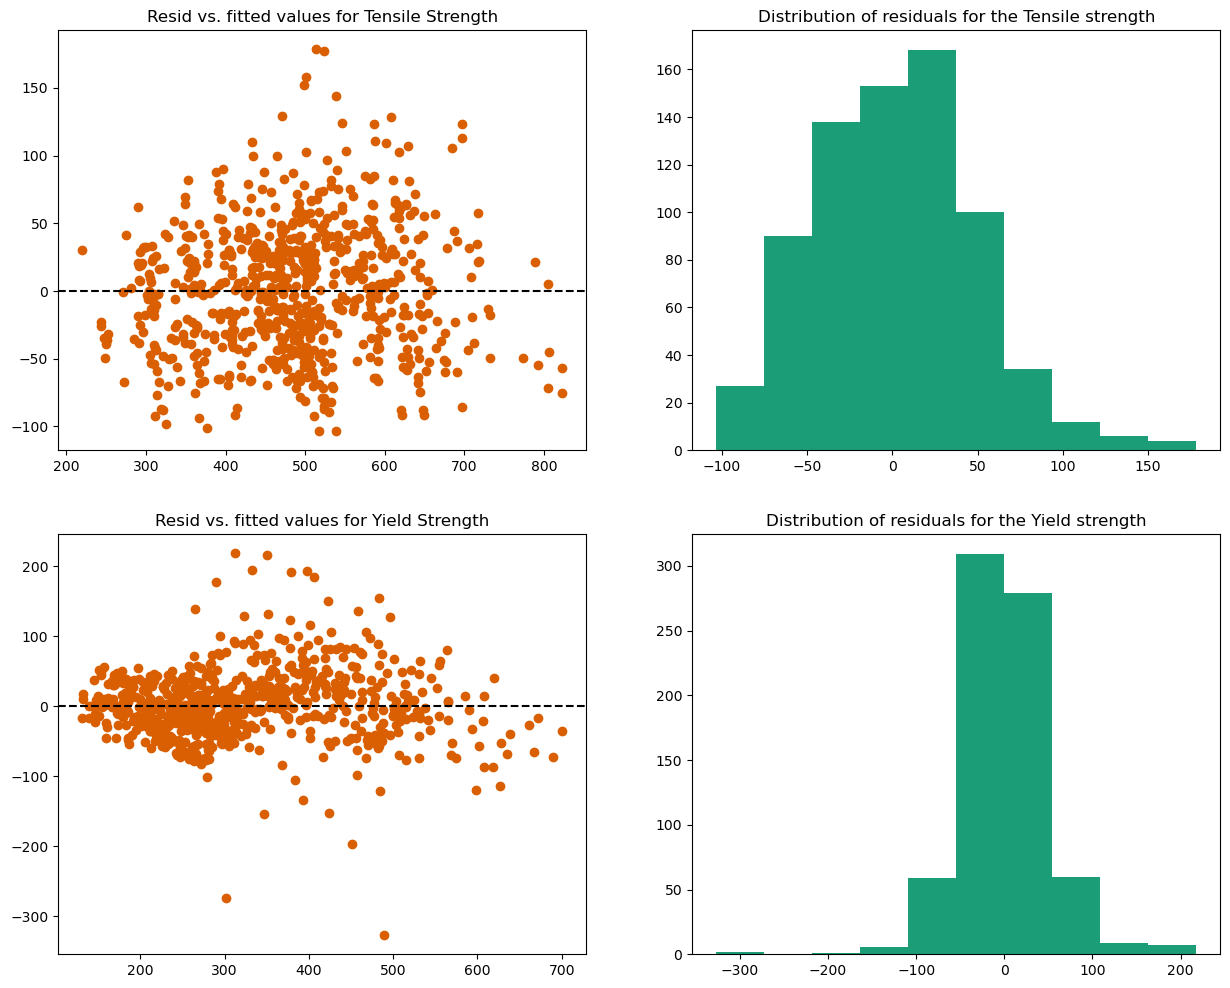

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs[0, 0].scatter(
    lasso_preds[:, 1],
    train["tensile_strength_mpa"] - lasso_preds[:, 1],
    color=color_palette[1],
)
axs[0, 0].axhline(0, color="k", linestyle="--")
axs[0, 0].set_title(f"Resid vs. fitted values for Tensile Strength")
axs[0, 1].hist(
    train["tensile_strength_mpa"] - lasso_preds[:, 1], color=color_palette[0]
)
axs[0, 1].set_title("Distribution of residuals for the Tensile strength")
axs[1, 0].scatter(
    lasso_preds[:, 0],
    train["yield_strength_mpa"] - lasso_preds[:, 0],
    color=color_palette[1],
)
axs[1, 0].axhline(0, color="k", linestyle="--")
axs[1, 0].set_title(f"Resid vs. fitted values for Yield Strength")
axs[1, 1].hist(train["yield_strength_mpa"] - lasso_preds[:, 0], color=color_palette[0])
axs[1, 1].set_title("Distribution of residuals for the Yield strength")

In [55]:
train_preds_lasso = pd.concat(
    [
        train.reset_index(drop=True),
        pd.DataFrame(
            lasso_preds, columns=["pred_yield_strength", "pred_tensile_strength"]
        ),
    ],
    axis=1,
).assign(
    abs_diff_yield=lambda x: abs(x.yield_strength_mpa - x.pred_yield_strength),
    abs_diff_tensile=lambda x: abs(x.tensile_strength_mpa - x.pred_tensile_strength),
)

In [63]:
# Looks like there is extreme values in the yield strength predictions, lets investigate

train_preds_lasso.nlargest(2, "abs_diff_yield")

,alloy_code,carbon,silicon,manganese,phosphorus,sulphur,nickel,chromium,molybdenum,cooper,...,nitrogen,carbon_equivalent,niobium_tantalum,temperature_c,yield_strength_mpa,tensile_strength_mpa,pred_yield_strength,pred_tensile_strength,abs_diff_yield,abs_diff_tensile
522,VbM,0.18,0.39,0.63,0.012,0.012,0.23,1.22,0.89,0.17,...,0.0103,0.000,0.0,200,162,603,489.001052,655.472098,327.001052,52.472098
708,CbZ,0.16,0.41,1.48,0.014,0.010,0.02,0.02,0.01,0.03,...,0.0079,0.436,0.0,550,27,375,301.389481,360.186856,274.389481,14.813144


In [58]:
train_preds_lasso[train_preds_lasso["alloy_code"] == "VbM"].sort_values("temperature_c")

,alloy_code,carbon,silicon,manganese,phosphorus,sulphur,nickel,chromium,molybdenum,cooper,...,nitrogen,carbon_equivalent,niobium_tantalum,temperature_c,yield_strength_mpa,tensile_strength_mpa,pred_yield_strength,pred_tensile_strength,abs_diff_yield,abs_diff_tensile
520,VbM,0.18,0.39,0.63,0.012,0.012,0.23,1.22,0.89,0.17,...,0.0103,0.0,0.0,27,525,680,517.778198,616.163115,7.221802,63.836885
521,VbM,0.18,0.39,0.63,0.012,0.012,0.23,1.22,0.89,0.17,...,0.0103,0.0,0.0,100,499,635,509.146235,644.241770,10.146235,9.241770
522,VbM,0.18,0.39,0.63,0.012,0.012,0.23,1.22,0.89,0.17,...,0.0103,0.0,0.0,200,162,603,489.001052,655.472098,327.001052,52.472098
523,VbM,0.18,0.39,0.63,0.012,0.012,0.23,1.22,0.89,0.17,...,0.0103,0.0,0.0,300,459,601,459.236704,635.218518,0.236704,34.218518
524,VbM,0.18,0.39,0.63,0.012,0.012,0.23,1.22,0.89,0.17,...,0.0103,0.0,0.0,400,473,587,419.853192,583.481028,53.146808,3.518972
525,VbM,0.18,0.39,0.63,0.012,0.012,0.23,1.22,0.89,0.17,...,0.0103,0.0,0.0,450,434,542,396.554250,545.805817,37.445750,3.805817
526,VbM,0.18,0.39,0.63,0.012,0.012,0.23,1.22,0.89,0.17,...,0.0103,0.0,0.0,500,411,498,370.850516,500.259628,40.149484,2.259628
527,VbM,0.18,0.39,0.63,0.012,0.012,0.23,1.22,0.89,0.17,...,0.0103,0.0,0.0,550,380,446,342.741991,446.842462,37.258009,0.842462
528,VbM,0.18,0.39,0.63,0.012,0.012,0.23,1.22,0.89,0.17,...,0.0103,0.0,0.0,600,323,386,312.228676,385.554319,10.771324,0.445681
529,VbM,0.18,0.39,0.63,0.012,0.012,0.23,1.22,0.89,0.17,...,0.0103,0.0,0.0,650,262,333,279.310569,316.395199,17.310569,16.604801


In [59]:
# Looks like a data entry error, I will correct it manually
train.loc[
    (train["alloy_code"] == "VbM") & (train["temperature_c"] == 200),
    "yield_strength_mpa",
] = 462

In [60]:
# What about the second row
train_preds_lasso[train_preds_lasso["alloy_code"] == "CbZ"].sort_values("temperature_c")

,alloy_code,carbon,silicon,manganese,phosphorus,sulphur,nickel,chromium,molybdenum,cooper,...,nitrogen,carbon_equivalent,niobium_tantalum,temperature_c,yield_strength_mpa,tensile_strength_mpa,pred_yield_strength,pred_tensile_strength,abs_diff_yield,abs_diff_tensile
700,CbZ,0.16,0.41,1.48,0.014,0.01,0.02,0.02,0.01,0.03,...,0.0079,0.436,0.0,27,577,693,531.115062,610.780114,45.884938,82.219886
701,CbZ,0.16,0.41,1.48,0.014,0.01,0.02,0.02,0.01,0.03,...,0.0079,0.436,0.0,100,546,663,513.991711,624.529807,32.008289,38.470193
702,CbZ,0.16,0.41,1.48,0.014,0.01,0.02,0.02,0.01,0.03,...,0.0079,0.436,0.0,200,542,679,482.666279,617.703422,59.333721,61.296578
703,CbZ,0.16,0.41,1.48,0.014,0.01,0.02,0.02,0.01,0.03,...,0.0079,0.436,0.0,300,483,664,442.243985,581.210469,40.756015,82.789531
704,CbZ,0.16,0.41,1.48,0.014,0.01,0.02,0.02,0.01,0.03,...,0.0079,0.436,0.0,350,487,655,418.621515,551.839030,68.378485,103.160970
705,CbZ,0.16,0.41,1.48,0.014,0.01,0.02,0.02,0.01,0.03,...,0.0079,0.436,0.0,400,452,583,392.724830,515.050950,59.275170,67.949050
706,CbZ,0.16,0.41,1.48,0.014,0.01,0.02,0.02,0.01,0.03,...,0.0079,0.436,0.0,450,404,513,364.553929,470.846227,39.446071,42.153773
707,CbZ,0.16,0.41,1.48,0.014,0.01,0.02,0.02,0.01,0.03,...,0.0079,0.436,0.0,500,360,450,334.108813,419.224862,25.891187,30.775138
708,CbZ,0.16,0.41,1.48,0.014,0.01,0.02,0.02,0.01,0.03,...,0.0079,0.436,0.0,550,27,375,301.389481,360.186856,274.389481,14.813144
709,CbZ,0.16,0.41,1.48,0.014,0.01,0.02,0.02,0.01,0.03,...,0.0079,0.436,0.0,600,198,313,266.395934,293.732207,68.395934,19.267793


In [62]:
# Again, looks like a data entry error, I will change the value manually

train.loc[
    (train["alloy_code"] == "CbZ") & (train["temperature_c"] == 550),
    "yield_strength_mpa",
] = 270

## Support Vector Machine

In [64]:
scaler = StandardScaler()
svr = SVR()
multi_svr = MultiOutputRegressor(svr)

svr_poly_pipe = make_pipeline(scaler, multi_svr)
svr_poly_pipe.steps

[('standardscaler', StandardScaler()),
 ('multioutputregressor', MultiOutputRegressor(estimator=SVR()))]

In [65]:
params_grid_svr = {
    "multioutputregressor__estimator__kernel": ["linear", "poly", "rbf"],
    "multioutputregressor__estimator__degree": [2, 3, 4, 5, 6, 7],
    "multioutputregressor__estimator__C": np.logspace(-2, 4, 50),
    "multioutputregressor__estimator__epsilon": np.logspace(-3, 1, 50),
}

svr_poly_rs = RandomizedSearchCV(
    svr_poly_pipe,
    params_grid_svr,
    scoring="neg_root_mean_squared_error",
    cv=group_folds,
    n_jobs=-1,
    n_iter=80,
)

svr_poly_rs.fit(train[predictors], train_target, groups=train["alloy_code"])

RandomizedSearchCV(cv=GroupKFold(n_splits=4),
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('multioutputregressor',
                                              MultiOutputRegressor(estimator=SVR()))]),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'multioutputregressor__estimator__C': array([1.00000000e-02, 1.32571137e-02, 1.75751062e-02, 2.32995181e-02,
       3.08884360e-02, 4.09491506e-02, 5.4...
       4.09491506e-01, 4.94171336e-01, 5.96362332e-01, 7.19685673e-01,
       8.68511374e-01, 1.04811313e+00, 1.26485522e+00, 1.52641797e+00,
       1.84206997e+00, 2.22299648e+00, 2.68269580e+00, 3.23745754e+00,
       3.90693994e+00, 4.71486636e+00, 5.68986603e+00, 6.86648845e+00,
       8.28642773e+00, 1.00000000e+01]),
                                        'multioutputregressor__estimator__kernel': ['linear',
                                                                                    'poly',
                                                                                    'rbf']},
                   scoring='neg_root_mean_squared_error')

In [66]:
svr_poly_rs.best_params_

{'multioutputregressor__estimator__kernel': 'rbf',
 'multioutputregressor__estimator__epsilon': 0.005428675439323859,
 'multioutputregressor__estimator__degree': 4,
 'multioutputregressor__estimator__C': 10000.0}

In [67]:
svr_poly_rs.best_score_

-48.17445931362078

In [68]:
svr_preds = evaluate_estimator(svr_poly_rs.best_estimator_)

The RMSE for the Yield strength is 54.06
The RMSE for the Tensile strength is 44.703


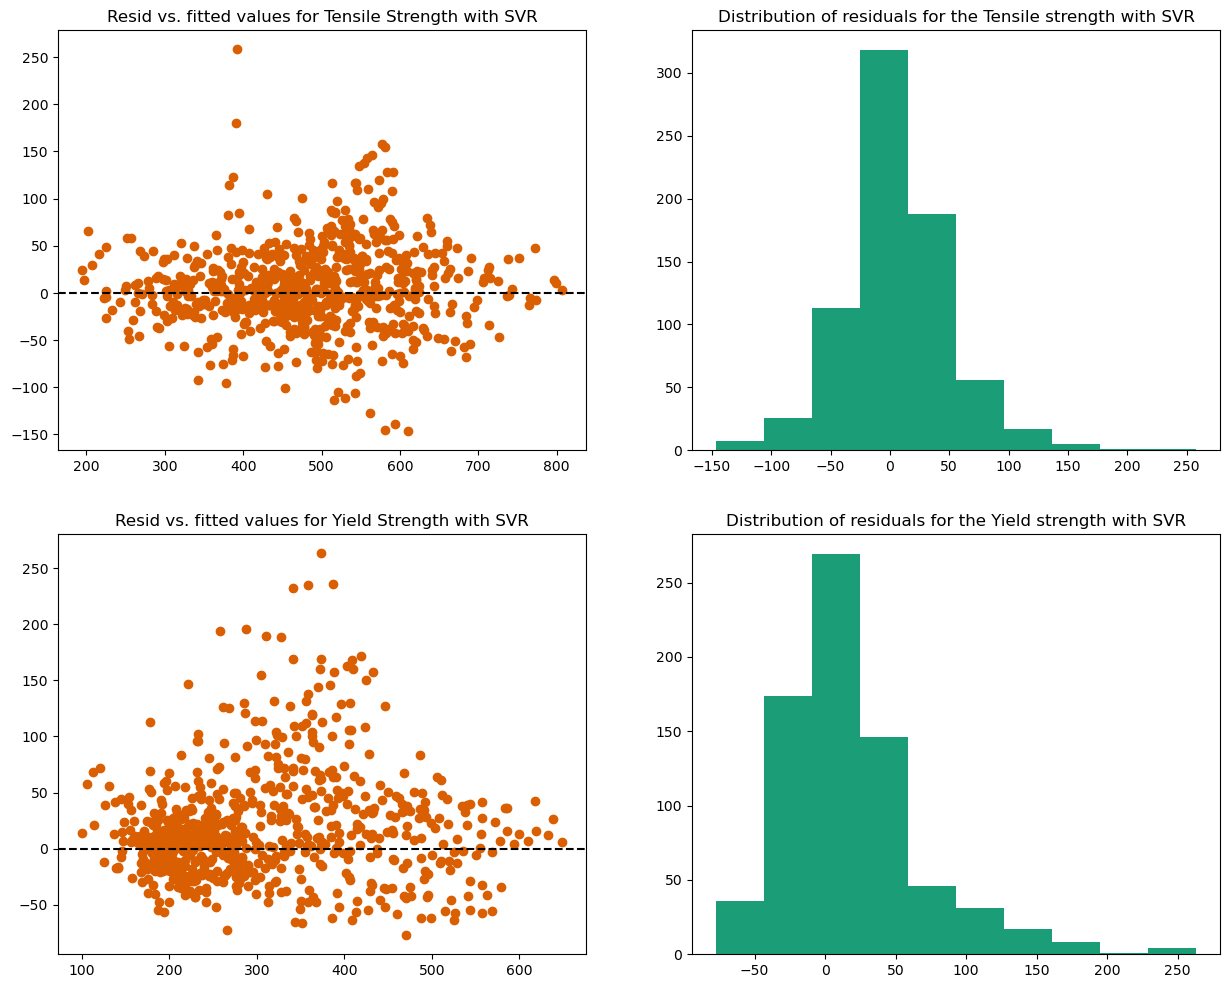

In [69]:
preds = svr_preds
classifier = "SVR"
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs[0, 0].scatter(
    preds[:, 1],
    train["tensile_strength_mpa"] - preds[:, 1],
    color=color_palette[1],
)
axs[0, 0].axhline(0, color="k", linestyle="--")
axs[0, 0].set_title(f"Resid vs. fitted values for Tensile Strength with {classifier}")
axs[0, 1].hist(train["tensile_strength_mpa"] - preds[:, 1], color=color_palette[0])
axs[0, 1].set_title(
    f"Distribution of residuals for the Tensile strength with {classifier}"
)
axs[1, 0].scatter(
    preds[:, 0],
    train["yield_strength_mpa"] - preds[:, 0],
    color=color_palette[1],
)
axs[1, 0].axhline(0, color="k", linestyle="--")
axs[1, 0].set_title(f"Resid vs. fitted values for Yield Strength with {classifier}")
axs[1, 1].hist(train["yield_strength_mpa"] - preds[:, 0], color=color_palette[0])
axs[1, 1].set_title(
    f"Distribution of residuals for the Yield strength with {classifier}"
)
plt.show()

In [89]:
joblib.dump(svr_poly_rs.best_estimator_, "../models/svr_poly_model.joblib")

['../models/svr_poly_model.joblib']

## Random Forest Regressor

In [70]:
from sklearn.ensemble import RandomForestRegressor

In [71]:
param_grid_rfr = {
    "n_estimators": [25, 50, 100, 150, 300, 500],
    "max_features": ["sqrt", "log2", None],
    "min_samples_split": [2, 5, 10, 15],
    "min_samples_leaf": [1, 3, 5],
    "ccp_alpha": np.arange(0, 3, 0.1),
}

rfr = RandomForestRegressor()

rfr_rs = RandomizedSearchCV(
    rfr,
    param_grid_rfr,
    scoring="neg_root_mean_squared_error",
    cv=group_folds,
    n_jobs=-1,
    n_iter=80,
)

rfr_rs.fit(train[predictors], train_target, groups=train["alloy_code"])

RandomizedSearchCV(cv=GroupKFold(n_splits=4), estimator=RandomForestRegressor(),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9]),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [25, 50, 100, 150, 300,
                                                         500]},
                   scoring='neg_root_mean_squared_error')

In [74]:
rfr_rs.best_score_

-34.57316466960091

In [72]:
rfr_preds = evaluate_estimator(rfr_rs.best_estimator_)

The RMSE for the Yield strength is 38.143
The RMSE for the Tensile strength is 32.043


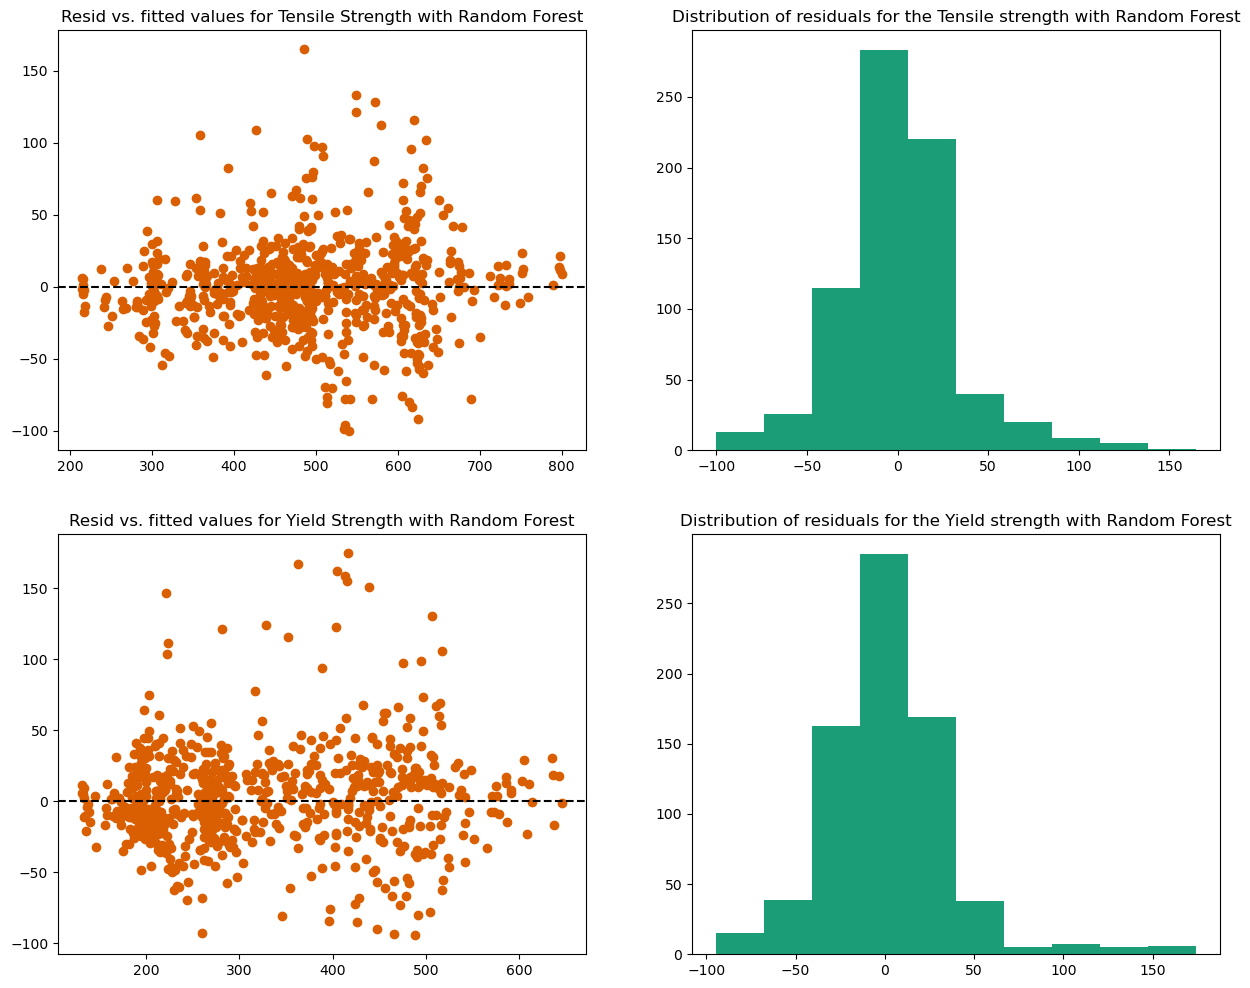

In [73]:
preds = rfr_preds
classifier = "Random Forest"
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs[0, 0].scatter(
    preds[:, 1],
    train["tensile_strength_mpa"] - preds[:, 1],
    color=color_palette[1],
)
axs[0, 0].axhline(0, color="k", linestyle="--")
axs[0, 0].set_title(f"Resid vs. fitted values for Tensile Strength with {classifier}")
axs[0, 1].hist(train["tensile_strength_mpa"] - preds[:, 1], color=color_palette[0])
axs[0, 1].set_title(
    f"Distribution of residuals for the Tensile strength with {classifier}"
)
axs[1, 0].scatter(
    preds[:, 0],
    train["yield_strength_mpa"] - preds[:, 0],
    color=color_palette[1],
)
axs[1, 0].axhline(0, color="k", linestyle="--")
axs[1, 0].set_title(f"Resid vs. fitted values for Yield Strength with {classifier}")
axs[1, 1].hist(train["yield_strength_mpa"] - preds[:, 0], color=color_palette[0])
axs[1, 1].set_title(
    f"Distribution of residuals for the Yield strength with {classifier}"
)
plt.show()

In [76]:
# There are two extreme values in the yield strength graph, let's try to localize them

train_preds_rfr = pd.concat(
    [
        train.reset_index(drop=True),
        pd.DataFrame(
            rfr_preds, columns=["pred_yield_strength", "pred_tensile_strength"]
        ),
    ],
    axis=1,
).assign(
    abs_diff_yield=lambda x: abs(x.yield_strength_mpa - x.pred_yield_strength),
    abs_diff_tensile=lambda x: abs(x.tensile_strength_mpa - x.pred_tensile_strength),
)

In [88]:
joblib.dump(rfr_rs.best_estimator_, "../models/rfr_model.joblib")

['../models/rfr_model.joblib']

## XGBoost Regressor

In [80]:
from xgboost import XGBRegressor

In [81]:
params = {
    "max_depth": [3, 6, 10, 15],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8],
    "subsample": np.arange(0.5, 1.0, 0.1),
    "colsample_bytree": np.arange(0.5, 1.0, 0.1),
    "colsample_bylevel": np.arange(0.5, 1.0, 0.1),
    "n_estimators": [100, 250, 500, 750],
    "alpha": [0.1, 1, 10, 100],
}

xgb = XGBRegressor()

xgb_rs = RandomizedSearchCV(
    xgb,
    params,
    scoring="neg_root_mean_squared_error",
    cv=group_folds,
    n_jobs=-1,
    n_iter=80,
)

xgb_rs.fit(train[predictors], train_target, groups=train["alloy_code"])

RandomizedSearchCV(cv=GroupKFold(n_splits=4),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                   n_iter=80, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 1, 10, 100],
                                        'colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3, 0.4, 0.6, 0.8],
                                        'max_depth': [3, 6, 10, 15],
                                        'n_estimators': [100, 250, 500, 750],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='neg_root_mean_squared_error')

In [82]:
xgb_rs.best_score_

-34.30553481162372

In [84]:
xgb_preds = evaluate_estimator(xgb_rs.best_estimator_)

The RMSE for the Yield strength is 39.072
The RMSE for the Tensile strength is 30.743


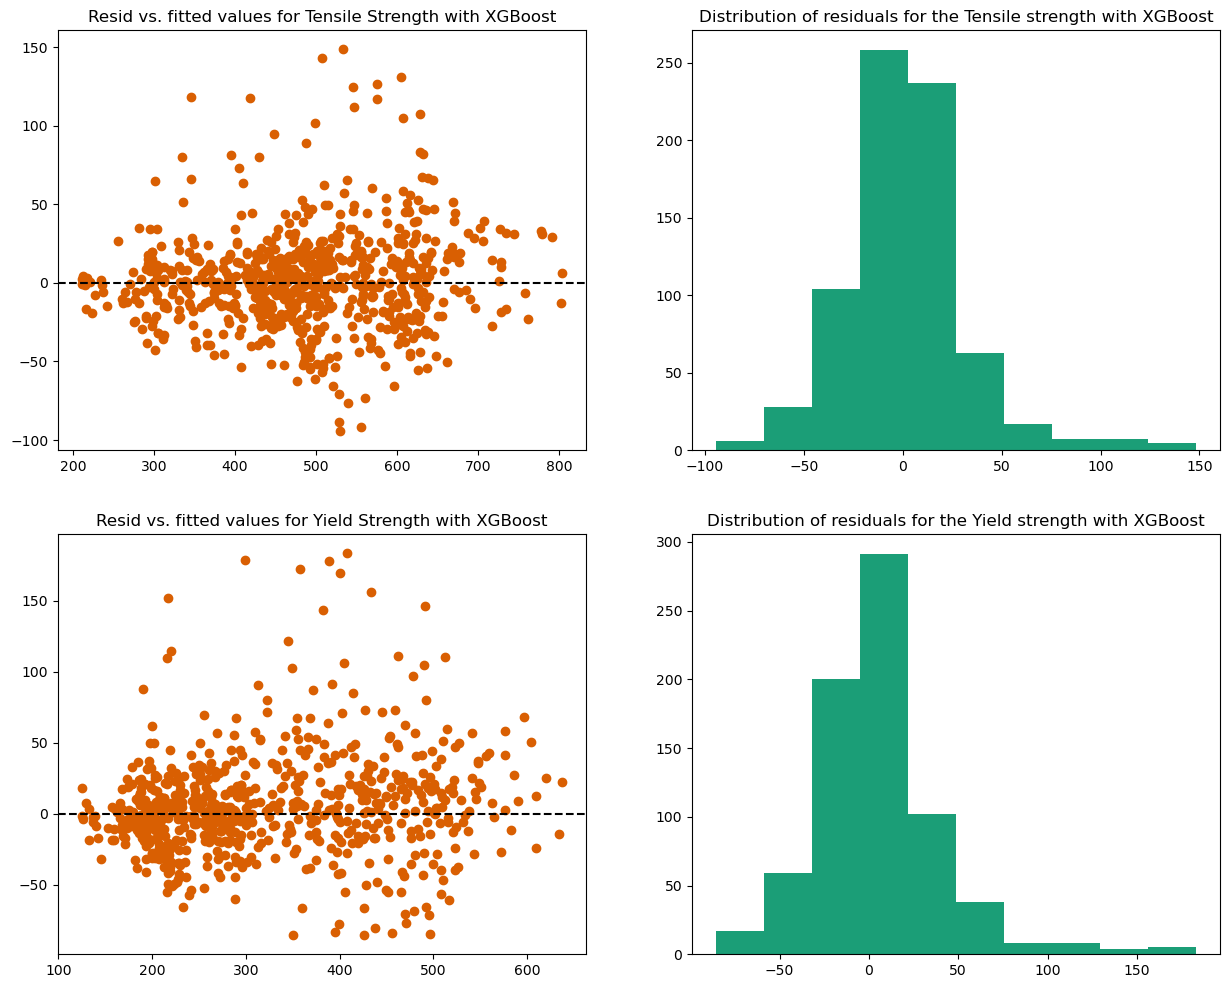

In [85]:
preds = xgb_preds
classifier = "XGBoost"
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs[0, 0].scatter(
    preds[:, 1],
    train["tensile_strength_mpa"] - preds[:, 1],
    color=color_palette[1],
)
axs[0, 0].axhline(0, color="k", linestyle="--")
axs[0, 0].set_title(f"Resid vs. fitted values for Tensile Strength with {classifier}")
axs[0, 1].hist(train["tensile_strength_mpa"] - preds[:, 1], color=color_palette[0])
axs[0, 1].set_title(
    f"Distribution of residuals for the Tensile strength with {classifier}"
)
axs[1, 0].scatter(
    preds[:, 0],
    train["yield_strength_mpa"] - preds[:, 0],
    color=color_palette[1],
)
axs[1, 0].axhline(0, color="k", linestyle="--")
axs[1, 0].set_title(f"Resid vs. fitted values for Yield Strength with {classifier}")
axs[1, 1].hist(train["yield_strength_mpa"] - preds[:, 0], color=color_palette[0])
axs[1, 1].set_title(
    f"Distribution of residuals for the Yield strength with {classifier}"
)
plt.show()

In [87]:
# Since XGboost is the best score estimator, this is the one that I will use for predictions later

joblib.dump(xgb_rs.best_estimator_, "../models/xgb_model.joblib")

['../models/xgb_model.joblib']

In [90]:
test

,alloy_code,carbon,silicon,manganese,phosphorus,sulphur,nickel,chromium,molybdenum,cooper,vanadium,aluminum,nitrogen,carbon_equivalent,niobium_tantalum,temperature_c,yield_strength_mpa,tensile_strength_mpa
0,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.970,0.610,0.04,0.000,0.003,0.0066,0.000,0.0,27,342,490
1,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.970,0.610,0.04,0.000,0.003,0.0066,0.000,0.0,100,338,454
2,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.970,0.610,0.04,0.000,0.003,0.0066,0.000,0.0,200,337,465
3,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.970,0.610,0.04,0.000,0.003,0.0066,0.000,0.0,300,346,495
4,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.970,0.610,0.04,0.000,0.003,0.0066,0.000,0.0,400,316,489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,CbR,0.16,0.29,1.42,0.013,0.006,0.041,0.054,0.011,0.08,0.079,0.006,0.0048,0.429,0.0,400,422,551
179,CbR,0.16,0.29,1.42,0.013,0.006,0.041,0.054,0.011,0.08,0.079,0.006,0.0048,0.429,0.0,450,388,505
180,CbR,0.16,0.29,1.42,0.013,0.006,0.041,0.054,0.011,0.08,0.079,0.006,0.0048,0.429,0.0,500,303,408
181,CbR,0.16,0.29,1.42,0.013,0.006,0.041,0.054,0.011,0.08,0.079,0.006,0.0048,0.429,0.0,550,251,343


In [92]:
# Evaluation of model on test data

mean_squared_error(
    test[["yield_strength_mpa", "tensile_strength_mpa"]],
    xgb_rs.best_estimator_.predict(test[predictors]),
    squared=False,
    multioutput="raw_values",
)

array([42.31753999, 22.3513928 ])

In [99]:
predictors_dict = {}

for predictor in predictors:
    predictors_dict[predictor] = (steel[predictor].min(), steel[predictor].max())

predictors_dict

{'carbon': (0.09, 0.34),
 'silicon': (0.18, 0.52),
 'manganese': (0.42, 1.48),
 'phosphorus': (0.006, 0.03),
 'sulphur': (0.003, 0.022),
 'nickel': (0.0, 0.6),
 'chromium': (0.0, 1.31),
 'molybdenum': (0.005, 1.35),
 'cooper': (0.0, 0.25),
 'vanadium': (0.0, 0.3),
 'aluminum': (0.002, 0.05),
 'nitrogen': (0.0025, 0.015),
 'niobium_tantalum': (0.0, 0.0017),
 'temperature_c': (27, 650)}

In [100]:
import pickle

with open("../models/predictors.pkl", "wb") as f:
    pickle.dump(predictors_dict, f)